In [1]:
import lightgbm as lgb, catboost as cat

In [2]:
import pandas as pd
import joblib

In [3]:
import numpy as np
import random

In [4]:
np.random.seed(42)
random.seed(42)

In [5]:
def read_merge_data(data_type="training"):
    #
    Dfs = []
    train_df = []
    train_output = pd.read_csv("./data_phase_one/training_output.csv", header=None)
    coords = pd.read_csv("data_phase_one/coords.csv", header=None)
    for name in ["mslp", "sst", "ssta", "t2m"]:
        df = pd.read_csv(f"./data_phase_one/{data_type}_input_{name}.csv", header=None)
        print("Shape df", df.shape)
        Dfs.append(df)
    j = 0
    for i in range(0, df.shape[0]-12, 1):
        feat = pd.concat([coords, Dfs[0].iloc[i:i+12], Dfs[1].iloc[i:i+12], Dfs[2].iloc[i:i+12], Dfs[3].iloc[i:i+12]], axis=0).reset_index(drop=True)
        tgt = train_output.iloc[i+11]
        tgt = tgt.T.reset_index(drop=True)
        feat = feat.T.reset_index(drop=True)
        feat = pd.concat([feat, tgt], axis=1)
        assert feat.shape[1]==51
        feat.columns = [f"feat_{k}" for k in range(feat.shape[1]-1)] + ["target"]
        if j < 3:
            print(feat.columns)
        train_df.append(feat)
        j += 1
    train_df = pd.concat(train_df, axis=0)
    #Dfs.index = [f"col_{i}" for i in range(848)]
    return train_df

In [6]:
#pd.read_csv("data_phase_one/coords.csv", header=None)

In [7]:
data = read_merge_data()

Shape df (849, 5774)
Shape df (849, 5774)
Shape df (849, 5774)
Shape df (849, 5774)
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24',
       'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30',
       'feat_31', 'feat_32', 'feat_33', 'feat_34', 'feat_35', 'feat_36',
       'feat_37', 'feat_38', 'feat_39', 'feat_40', 'feat_41', 'feat_42',
       'feat_43', 'feat_44', 'feat_45', 'feat_46', 'feat_47', 'feat_48',
       'feat_49', 'target'],
      dtype='object')
Index(['feat_0', 'feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6',
       'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12',
       'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18',
       'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23'

In [8]:
#y = train_df["target"]

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [10]:
cv = KFold(n_splits=5, shuffle=True)

In [11]:
params_lgb = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "rmse",
    "max_depth": 8,
    'num_leaves': 255,
    "learning_rate": 0.01,
    "n_estimators": 2000,
    #"colsample_bytree": 0.8, 
    #"colsample_bynode": 0.8,
    "verbose": -1,
    "device": "gpu",
    "gpu_device_id": 1}

In [16]:
params_catb = dict(
task_type="GPU",
devices='1',
reg_lambda=0.438, learning_rate=0.1,
max_depth=8, min_data_in_leaf=50,
n_estimators=2000, verbose=50,
objective='RMSE')

In [13]:
params_catb

{'task_type': 'GPU',
 'devices': '1',
 'reg_lambda': 0.438,
 'learning_rate': 0.01,
 'max_depth': 8,
 'min_data_in_leaf': 50,
 'n_estimators': 2000,
 'verbose': 50,
 'objective': 'RMSE'}

In [14]:
for state, (train_idx, val_idx) in enumerate(cv.split(data)):
    X_train = data.drop(columns=["target"]).iloc[train_idx].values
    X_val = data.drop(columns=["target"]).iloc[val_idx].values
    y_train = data["target"].iloc[train_idx].values
    y_val = data["target"].iloc[val_idx].values
    print(f"\nTrain: {len(y_train)}, Val: {len(y_val)}\n")
    lgb_model = lgb.LGBMRegressor(**params_lgb, random_state=state)
    lgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)])
    joblib.dump(lgb_model, f"./kfold_trained2/lgb_model_fold{state}.joblib")


Train: 3866270, Val: 966568


Train: 3866270, Val: 966568


Train: 3866270, Val: 966568


Train: 3866271, Val: 966567


Train: 3866271, Val: 966567



In [17]:
for state, (train_idx, val_idx) in enumerate(cv.split(data)):
    X_train = data.drop(columns=["target"]).iloc[train_idx].values
    X_val = data.drop(columns=["target"]).iloc[val_idx].values
    y_train = data["target"].iloc[train_idx].values
    y_val = data["target"].iloc[val_idx].values
    print(f"\nTrain: {len(y_train)}, Val: {len(y_val)}\n")
    catb_model = cat.CatBoostRegressor(**params_catb, random_state=state)
    catb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)])
    joblib.dump(catb_model, f"./kfold_trained2/catb_model_fold{state}.joblib")


Train: 3866270, Val: 966568

0:	learn: 0.6051317	test: 0.6054069	best: 0.6054069 (0)	total: 20.7ms	remaining: 41.5s
50:	learn: 0.5306695	test: 0.5316948	best: 0.5316948 (50)	total: 1.02s	remaining: 39.1s
100:	learn: 0.5259155	test: 0.5272421	best: 0.5272421 (100)	total: 2.09s	remaining: 39.2s
150:	learn: 0.5229300	test: 0.5246307	best: 0.5246307 (150)	total: 3.15s	remaining: 38.6s
200:	learn: 0.5206516	test: 0.5227018	best: 0.5227018 (200)	total: 4.22s	remaining: 37.7s
250:	learn: 0.5186621	test: 0.5210165	best: 0.5210165 (250)	total: 5.28s	remaining: 36.8s
300:	learn: 0.5168155	test: 0.5195444	best: 0.5195444 (300)	total: 6.31s	remaining: 35.6s
350:	learn: 0.5152835	test: 0.5183324	best: 0.5183324 (350)	total: 7.36s	remaining: 34.6s
400:	learn: 0.5138776	test: 0.5172323	best: 0.5172323 (400)	total: 8.43s	remaining: 33.6s
450:	learn: 0.5124955	test: 0.5161393	best: 0.5161393 (450)	total: 9.46s	remaining: 32.5s
500:	learn: 0.5111608	test: 0.5151730	best: 0.5151730 (500)	total: 10.5s	re

In [18]:
pred_lgb = lgb_model.predict(X_val[:200])
pred_catb = catb_model.predict(X_val[:200])

In [19]:
print("lgbm error:", np.linalg.norm(y_val[:200]-pred_lgb))
print("catboost error:", np.linalg.norm(y_val[:200]-pred_catb))

lgbm error: 4.852459555035922
catboost error: 4.8074272450669975


In [20]:
import matplotlib.pyplot as plt

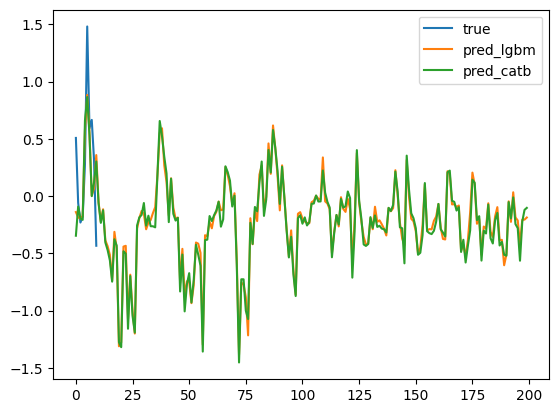

In [21]:
plt.plot(y_val[:10])
plt.plot(pred_lgb)
plt.plot(pred_catb)
plt.legend(["true", "pred_lgbm", "pred_catb"])
plt.show()